#### Import required layers and utils from the framework

In [1]:
import keras

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, merge, Input, Lambda
from keras.layers import Convolution2D, Convolution3D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization, LRN2D
from keras import backend as K


from theano.sandbox.cuda.dnn import *

Using Theano backend.
Using gpu device 0: Tesla K40m (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5005)


#### Import other required utils

In [3]:
from copy import deepcopy
import cv2
import datetime
import dicom
from fnmatch import fnmatch
import h5py
import numpy as np
from os import path, walk
import pickle
from PIL import Image, ImageDraw
# import pysftp
import re
import time
from matplotlib import pyplot as plt
from scipy.misc.pilutil import imresize

%matplotlib inline
plt.set_cmap('gray')

#### sci-kit learn stuff

In [4]:
from sklearn.cross_validation import train_test_split

In [5]:
EXPERIMENT_NAME = "lungs_detection"
DO_LRN = False # LRN is Local Response Normalization (lateral inhibition)

INPUT_FOLDER = "/home/a.kondyukov/data/whole/TbDispensary/"
INPUT_MASK = r"(.*).dcm"
GROUND_FOLDER = "/home/a.kondyukov/data/lungs/TbDispensary/lungs_masks/"
GROUND_MASK = r"(.*).npz"

BATCH_SIZE = 5
EPOCH_NUM = 400
WHOLE_SET_SIZE = 90
X_IMAGE_SIZE = 320
MODEL_FILENAME = "%s_u-net_%s" % (EXPERIMENT_NAME, datetime.date.today().strftime("%d%b%Y"))

In [6]:
def open_file(filename):
    if re.match(r'(.*).dcm', filename):
        return dicom.read_file(filename).pixel_array
    
    if re.match(r'(.*).(npz|npy)', filename):
        np_file = np.load(filename)
        key = list(np_file.keys())[0]
        if len(np_file.keys()) > 1:
            print("WARNING: %s file has more than one variable stored, using variable %s." % (filename, key))
            
        return np_file[key]

In [7]:
def get_files_from_folder(folder, mask, files_num):
    result = []
    for directory, _, files in walk(folder):
        for filename in sorted(files):
            file = path.join(directory, filename)
            if re.match(folder + mask, file):
                result.append(imresize(open_file(file), [X_IMAGE_SIZE, X_IMAGE_SIZE]))

            if len(result) == files_num:
                return result
            
    return result

#### This version of U-net uses zero-padding so as to leave image size unchanged

In [8]:
def get_u_net():
    main_input = Input(shape=(1, X_IMAGE_SIZE, X_IMAGE_SIZE))
    input_shape = (-1, 1, X_IMAGE_SIZE, X_IMAGE_SIZE)

    convolution_1_1 = Convolution2D(8, 3, 3, \
                                    input_shape=input_shape, activation='relu', border_mode='same')(main_input)
    convolution_1_2 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(convolution_1_1)
    pool_1 = MaxPooling2D(pool_size=(2, 2))(convolution_1_2)

    if DO_LRN:
        normalize_1 = LRN2D()(pool_1)
        convolution_2_1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(normalize_1)
    else:
        convolution_2_1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(pool_1)
    convolution_2_2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(convolution_2_1)
    pool_2 = MaxPooling2D(pool_size=(2, 2))(convolution_2_2)

    if DO_LRN:
        normalize_2 = LRN2D()(pool_2)
        convolution_3_1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(normalize_2)
    else:
        convolution_3_1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool_2)
    convolution_3_2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(convolution_3_1)
    pool_3 = MaxPooling2D(pool_size=(2, 2))(convolution_3_2)

    if DO_LRN:
        normalize_3 = LRN2D()(pool_3)
        convolution_4_1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(normalize_3)
    else:
        convolution_4_1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool_3)
    convolution_4_2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(convolution_4_1)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(convolution_4_2)

    if DO_LRN:
        normalize_4 = LRN2D()(pool_4)
        convolution_5_1 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(normalize_4)
    else:
        convolution_5_1 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool_4)
    convolution_5_2 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(convolution_5_1)

    first_upsampled = UpSampling2D(size=(2, 2))(convolution_5_2)
    first_merged = merge([first_upsampled, convolution_4_2], mode='concat', concat_axis=1)
    if DO_LRN:
        normalize_5 = LRN2D()(first_merged)
        convolution_6_1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(normalize_5)
    else:
        convolution_6_1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(first_merged)
    convolution_6_2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(convolution_6_1)

    second_upsampled = UpSampling2D(size=(2, 2))(convolution_6_2)
    second_merged = merge([second_upsampled, convolution_3_2], mode='concat', concat_axis=1)
    if DO_LRN:
        normalize_6 = LRN2D()(second_merged)
        convolution_7_1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(normalize_6)
    else:
        convolution_7_1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(second_merged)
    convolution_7_2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(convolution_7_1)

    third_upsampled = UpSampling2D(size=(2, 2))(convolution_7_2)
    third_merged = merge([third_upsampled, convolution_2_2], mode='concat', concat_axis=1)
    if DO_LRN:
        normalize_7 = LRN2D()(third_merged)
        convolution_8_1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(normalize_7)
    else:
        convolution_8_1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(third_merged)
    convolution_8_2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(convolution_8_1)

    fourth_upsampled = UpSampling2D(size=(2, 2))(convolution_8_2)
    fourth_merged = merge([fourth_upsampled, convolution_1_2], mode='concat', concat_axis=1)
    if DO_LRN:
        normalize_8 = LRN2D()(fourth_merged)
        convolution_9_1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(normalize_8)
    else:
        convolution_9_1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(fourth_merged)
    convolution_9_2 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(convolution_9_1)

    convolution_10_1 = Convolution2D(1, 1, 1, activation='sigmoid')(convolution_9_2)
    
    return Model(input=main_input, output=convolution_10_1) 

In [9]:
model = get_u_net()
model.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
X = get_files_from_folder(INPUT_FOLDER, INPUT_MASK, WHOLE_SET_SIZE)
Y = get_files_from_folder(GROUND_FOLDER, GROUND_MASK, WHOLE_SET_SIZE)
            
X = np.expand_dims(X, 1)
Y = np.expand_dims(Y, 1)

X_train, X_validate, Y_train, Y_validate = train_test_split(X, Y)

In [11]:
datagen = ImageDataGenerator(
                    featurewise_center=False,
                    featurewise_std_normalization=False,
                    rotation_range=10.,
                    zoom_range=0.2,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    fill_mode='constant',
                    cval=0.,
                    horizontal_flip=True)

for e in range(EPOCH_NUM):
    print('Epoch', e)
    batches = 0
    
    X_batch = np.zeros((BATCH_SIZE, 1, X_IMAGE_SIZE, X_IMAGE_SIZE))
    Y_batch = np.zeros((BATCH_SIZE, 1, X_IMAGE_SIZE, X_IMAGE_SIZE))

    train_losses = []
    epoch_finished = False
    start = time.time()

    for X_batch in datagen.flow(np.concatenate([X_train, Y_train], axis=1), batch_size=5):
        Y_batch = np.expand_dims(X_batch[:, 1, :, :], 1)
        X_batch = np.expand_dims(X_batch[:, 0, :, :], 1)

        loss = model.train_on_batch(X_batch, Y_batch)
        train_losses.append(loss)
        batches += 1
        if batches >= len(X_train) / 5:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            validation_loss = model.evaluate(X_validate, Y_validate, verbose=0)
            print('train loss: ', np.mean(train_losses), 
                  'validation loss: ', validation_loss)
            break
                
    if e % 50 == 0:
        model.save_weights(MODEL_FILENAME + '_' + str(e) + '.h5', overwrite=True)
    print('Time per epoch: ', time.time() - start)
        

model.save_weights(MODEL_FILENAME + '.h5', overwrite=True)

Epoch 0
train loss:  1.04633 validation loss:  0.723147630692
Time per epoch:  323.3607614040375
Epoch 1
train loss:  0.690976 validation loss:  0.716089844704
Time per epoch:  3.7077324390411377
Epoch 2
train loss:  0.628326 validation loss:  0.534346759319
Time per epoch:  3.7059762477874756
Epoch 3
train loss:  0.649969 validation loss:  0.686335027218
Time per epoch:  3.7055487632751465
Epoch 4
train loss:  0.684118 validation loss:  0.682243943214
Time per epoch:  3.7050323486328125
Epoch 5
train loss:  0.680808 validation loss:  0.681050956249
Time per epoch:  3.704059600830078
Epoch 6
train loss:  0.679718 validation loss:  0.679738819599
Time per epoch:  3.703141450881958
Epoch 7
train loss:  0.676302 validation loss:  0.679284930229
Time per epoch:  3.7001686096191406
Epoch 8
train loss:  0.677184 validation loss:  0.675088822842
Time per epoch:  3.7080421447753906
Epoch 9
train loss:  0.685739 validation loss:  0.670617282391
Time per epoch:  3.6986911296844482
Epoch 10
train

In [12]:
model.load_weights("./lungs_detection_u-net_15Aug2016_150.h5")

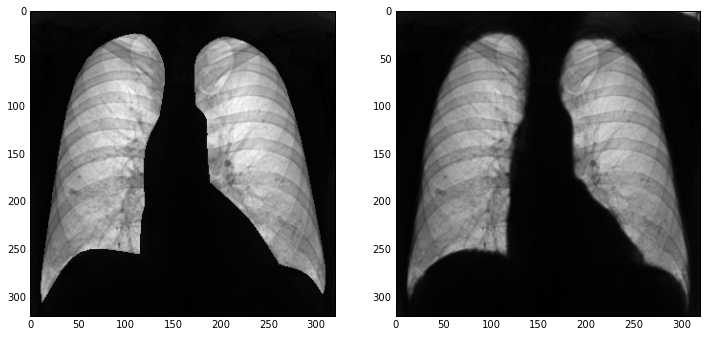

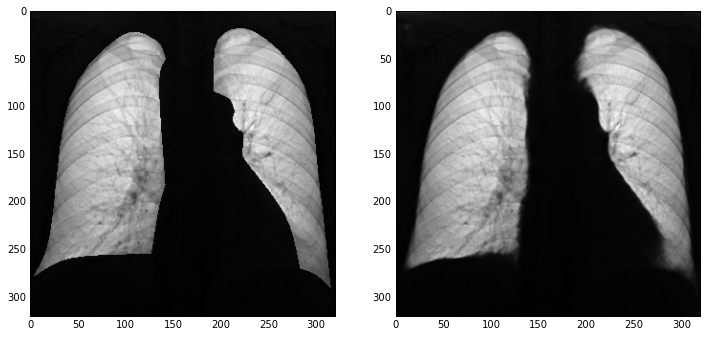

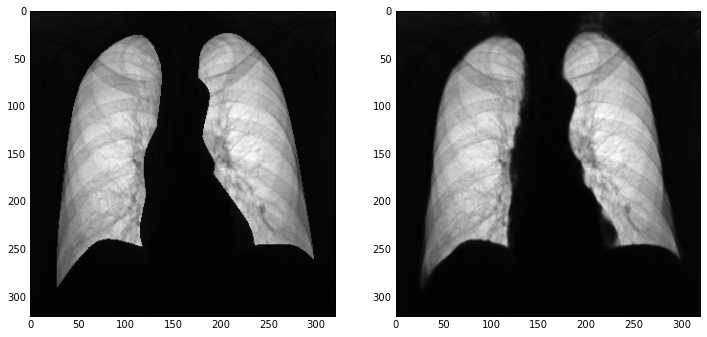

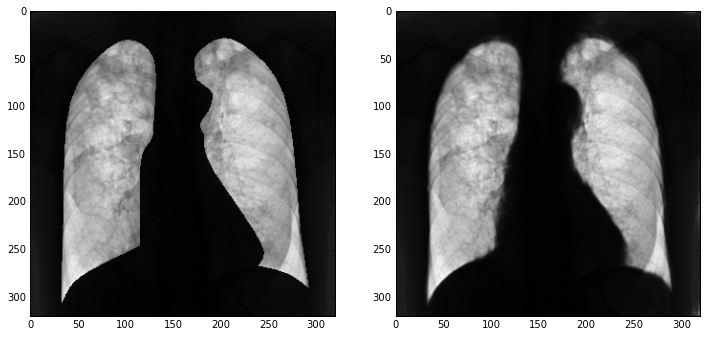

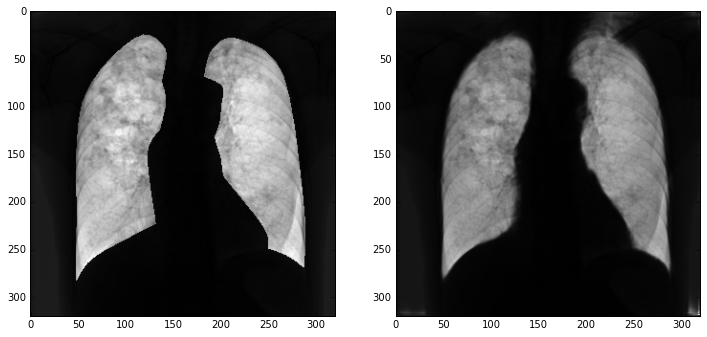

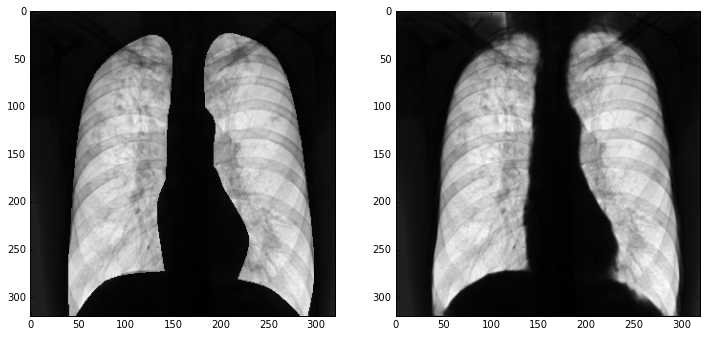

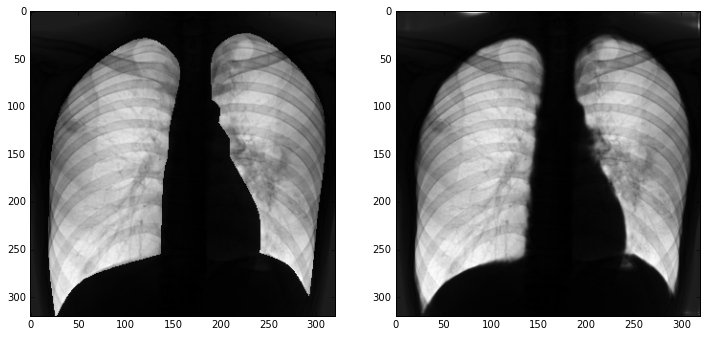

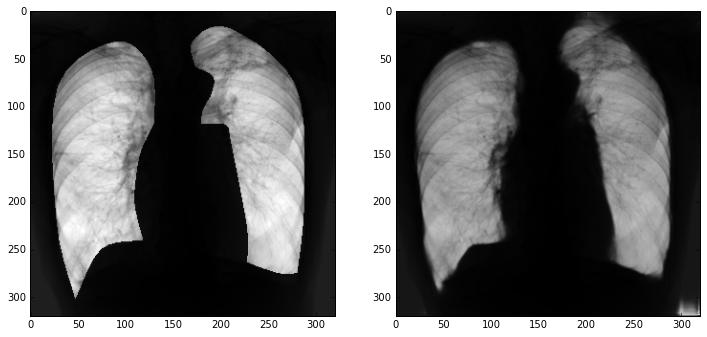

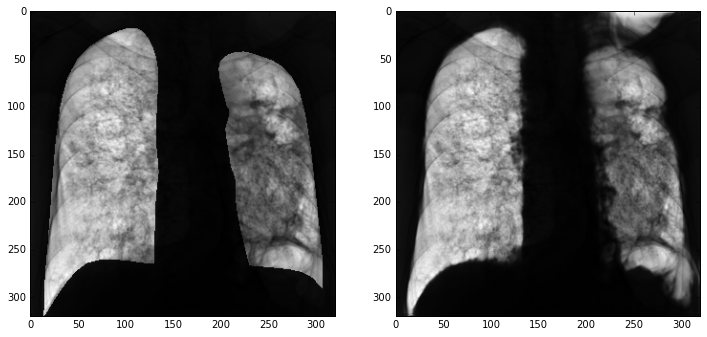

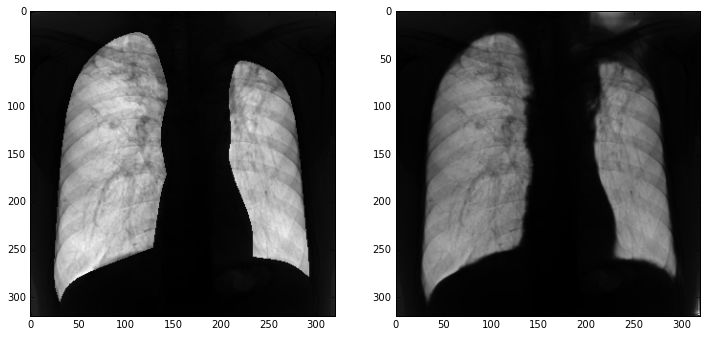

In [21]:
for i in range(10):
    plt.figure(i, figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow((Y[i][0] + 0.1) * X[i][0])
    plt.subplot(1, 2, 2)
    plt.imshow((model.predict(np.array([X[i]]))[0][0] + 0.1) * X[i][0])